Experimental Pooling
=========================

A better version of CNN pooling.

Imports
-------

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Load Data
---------

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(root="./cifardata", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root="./cifardata", train=False, download=True, transform=transform)

classes = ('plane', 
           'car', 
           'bird',
           'cat',
           'deer', 
           'dog', 
           'frog', 
           'horse',
           'ship',
           'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [96]:
from torch.utils.data.sampler import SubsetRandomSampler

#Training
n_training_samples = 20000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
def get_train_loader(batch_size):
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=2)
        return train_loader
    
#Validation
n_val_samples = 5000
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples+n_val_samples, dtype=np.int64))
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler, num_workers=2)

#Testing
n_test_samples = 5000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, sampler=test_sampler, num_workers=2)

In [122]:
class SortPool:
    def __init__(self, channels, height, width):
        self.channels = channels
        self.height = height
        self.width = width
        self.coeff = torch.rand(self.channels, self.height*self.width)#, requires_grad=True)
        
    def forward(self, x):
        batch_size, channels, height, width = x.shape
#         print("x1", x.shape)
        x = x.view(batch_size, channels, height*width)
#         print("x2", x.shape)
#         x, indices = torch.sort(x, dim=2, descending=True)
#         print("x3", x.shape)
        x = torch.mul(x, self.coeff)
#         print("x4", x.shape)
        y = torch.mean(x, dim=2)
#         print("y", y.shape)
        return y

In [123]:
from torch.autograd import Variable

class SimpleCNN(torch.nn.Module):
    
    #Batch shape of x: (3, 32, 32)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, Output channels = 18
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        
        self.pool = SortPool(18, 32, 32)
                        
        #1024 input features, 1 output feature
#         self.fc1 = torch.nn.Linear(32*32, 1)
        
        #1024 input features, 10 output features (for 10 defined classes)
        self.fc = torch.nn.Linear(18, 10)
                
        
    def forward(self, x):
        """
        Computes activation of the first convolution
        """
        #Dimension changes from (3, 32, 32) to (18, 32, 32)
        x = F.relu(self.conv1(x))
        
        #Dimension changes from (18, 32, 32) to (1, 18)
        x = self.pool.forward(x)

        
        #Dimension changes from (18, 32*32) to (18, 1)
#         x = F.relu(self.fc1(x))
        
        #Dimension changes from (18, 1) to (1, 18)
#         x = x.view(-1, 18*32*32)
        
        #Dimension changes from (1,1024) to (1, 10)
        x = F.relu(self.fc(x))
        
        sm = F.softmax(x)

        return x
    
    
    def output_size(in_size, kernel_size, stride, padding):
        """
        Determines the output size
        """
        output = int((in_size - kernel_size + 2*padding) / stride) + 1
        
        return output

In [7]:
import torch.optim as optim

def loss_and_optimizer(net, learning_rate=0.001):
    """
    Initializes the loss optimizer functions
    """
    loss = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return loss, optimizer

In [120]:
import time
import matplotlib.pyplot as plt

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size =", batch_size)
    print("epochs =", n_epochs)
    print("learning_rate =", learning_rate)
    print("=" * 30)
    
    validation_losses = []
    training_losses = []
    
    #Retrieve training data
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Initialize loss and optimizer functions
    loss, optimizer = loss_and_optimizer(net, learning_rate)
    
    
    training_start_time = time.time()
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
#             if epoch == 0:
#                 global img
#                 img = inputs
#                 target = inputs[0]
#                 imshow(target)
#                 print(classes[labels[0]])
            inputs, labels = Variable(inputs), Variable(labels)   
                        
            #Set parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)            
            loss_size = loss(outputs, labels)
            
            #Intermediate accuracy
#             _, predicted = torch.max(outputs.data, dim=1)
#             num_correct = (predicted == labels).sum().item()
#             intermediate_acc = (num_correct * 100.0 / labels.size(0))
            
            loss_size.backward()
            optimizer.step()
            
            #Update statistics
            running_loss += loss_size.data.item()
            total_train_loss += loss_size.data.item()
            
            #Print statistics every 10th batch of epoch
            if (i+1) % (print_every+1) == 0:
                print("Epoch {epoch}, {percent_complete_epoch:d}% \t train_loss: {train_loss:.2f} \t took: {time:.2f}s".format(
                    epoch = epoch+1, 
                    percent_complete_epoch = int(100 * (i+1) / n_batches), 
                    train_loss = running_loss / print_every, 
                    time = time.time() - start_time, 
#                     accuracy = intermediate_acc.item()
                ))
                
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #After each epoch, run a pass on validation set
        total_val_loss = 0
        
        for inputs, labels in val_loader:
            
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data.item()
        
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
        validation_losses.append(total_val_loss / len(val_loader))
        training_losses.append(running_loss / print_every)
        
        
        
    print("=" * 30)
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    
    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(0, n_epochs, n_epochs)
    plt.plot(x, training_losses)
    plt.plot(x, validation_losses)
    ax.legend(["train_loss", "val_loss"])
    

In [9]:
def accuracy(model):
    
    correct = 0
    total = 0
    
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    
    with torch.no_grad():
        
        for data in test_loader:

            #Run test data through model
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            
            
            #Updte statistics
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            #Class specific 
            c = (predicted == labels).squeeze()
            for i in range(len(predicted)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
        
        #Report accuracies
        overall_acc = (correct * 100.0) / total
        class_acc = {}
        for i in range(len(classes)):
            class_acc[classes[i]] = (class_correct[i] * 100) / class_total[i]
                

    return overall_acc, class_acc

===== HYPERPARAMETERS =====
batch_size = 32
epochs = 10
learning_rate = 0.001


/home/mattbev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1, 10% 	 train_loss: 2.34 	 took: 0.77s
Epoch 1, 20% 	 train_loss: 2.33 	 took: 0.60s
Epoch 1, 30% 	 train_loss: 2.31 	 took: 0.56s
Epoch 1, 40% 	 train_loss: 2.30 	 took: 0.57s
Epoch 1, 50% 	 train_loss: 2.29 	 took: 0.62s
Epoch 1, 60% 	 train_loss: 2.28 	 took: 0.60s
Epoch 1, 70% 	 train_loss: 2.27 	 took: 0.64s
Epoch 1, 80% 	 train_loss: 2.25 	 took: 0.58s
Epoch 1, 90% 	 train_loss: 2.25 	 took: 0.58s
Validation loss = 2.21
Epoch 2, 10% 	 train_loss: 2.24 	 took: 0.66s
Epoch 2, 20% 	 train_loss: 2.23 	 took: 0.63s
Epoch 2, 30% 	 train_loss: 2.23 	 took: 0.60s
Epoch 2, 40% 	 train_loss: 2.24 	 took: 0.55s
Epoch 2, 50% 	 train_loss: 2.24 	 took: 0.56s
Epoch 2, 60% 	 train_loss: 2.25 	 took: 0.58s
Epoch 2, 70% 	 train_loss: 2.25 	 took: 1.05s
Epoch 2, 80% 	 train_loss: 2.24 	 took: 0.61s
Epoch 2, 90% 	 train_loss: 2.22 	 took: 0.59s
Validation loss = 2.19
Epoch 3, 10% 	 train_loss: 2.22 	 took: 0.59s
Epoch 3, 20% 	 train_loss: 2.22 	 took: 0.58s
Epoch 3, 30% 	 train_loss: 2.23 	 

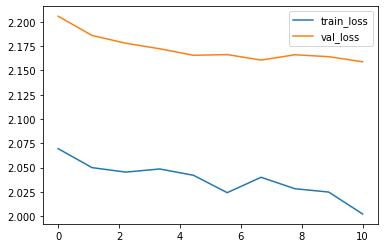

In [125]:
import json

CNN = SimpleCNN()
trainNet(CNN, batch_size=32, n_epochs=10, learning_rate=.001)
overall_acc, class_acc = accuracy(CNN)
print("Final Accuracies: \n overall: {overall_acc:.3f} \n class: {class_acc}".format(
    overall_acc=overall_acc, 
    class_acc=json.dumps(class_acc, indent=4)))

# outputs = CNN(img)
# _, predicted = torch.max(outputs, 1)
# print("Predicted:", classes[predicted[0]])

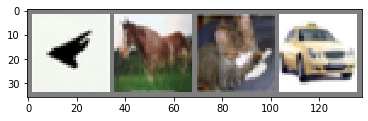

GroundTruth:  plane horse   cat   car
Predicted:  plane   cat   cat plane


/home/mattbev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [115]:
#Show images

dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = CNN(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))